In [9]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import datetime as dt
from dateutil.parser import parse
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.optimize import newton
#from scipy.special import psi, polygamma
from scipy.stats import norm, kde, kstest
from numpy import inf,linspace
import scipy.stats
from sklearn.preprocessing import scale


df = pd.read_csv('google_drive_nanreplaced.csv')

In [10]:
df.head()

,time,1day_active_users,1day_google_documents_active_users,1day_google_drawings_active_users,1day_google_forms_active_users,1day_google_presentations_active_users,1day_google_sites_active_users,1day_google_spreadsheets_active_users,1day_other_types_active_users,30day_active_users,...,owned_items_with_visibility_unknown_delta,owned_items_with_visibility_unknown_removed,owned_other_types_added,owned_other_types_created,owned_other_types_delta,owned_other_types_edited,owned_other_types_removed,owned_other_types_trashed,owned_other_types_viewed,sharers
0,2017-03-12 05:00:00,1543.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,3509.0,0.0,193.0,0.0,173.0,1173.0,0.0
1,2017-03-14 04:00:00,2495.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,6275.0,0.0,837.0,0.0,1018.0,1759.0,0.0
2,2017-03-16 04:00:00,2403.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,22084.0,0.0,820.0,0.0,805.0,1451.0,0.0
3,2017-03-19 04:00:00,2848.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,51355.0,0.0,725.0,0.0,737.0,1247.0,0.0
4,2017-03-20 04:00:00,5302.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,9979.0,0.0,1330.0,0.0,924.0,2339.0,0.0


In [11]:
y= df['1day_active_users']
y.describe()

count     831.000000
mean     3888.996114
std      2034.729698
min       396.000000
25%      2262.500000
50%      3632.000000
75%      5537.000000
max      9014.000000
Name: 1day_active_users, dtype: float64

In [20]:

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
yy=y.values.reshape(-1,1)
yy = sc.fit_transform(yy)
yy= yy.flatten()
y_std=yy
size = len(y)
x= np.arange(len(y))

In [21]:
# Set list of distributions to test
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

# Turn off code warnings (this is not recommended for routine use)
import warnings
warnings.filterwarnings("ignore")

# Set up list of candidate distributions to use
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

dist_names = ['beta',
              'expon',
              'gamma',
              'lognorm',
              'norm',
              'pearson3',
              'triang',
              'uniform',
              'weibull_min', 
              'weibull_max']

# Set up empty lists to store results
chi_square = []
p_values = []

# Set up 50 bins for chi-square test
# Observed data will be approximately evenly distrubuted aross all bins
percentile_bins = np.linspace(0,100,51)
percentile_cutoffs = np.percentile(y_std, percentile_bins)
observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
cum_observed_frequency = np.cumsum(observed_frequency)

# Loop through candidate distributions

for distribution in dist_names:
    # Set up distribution and get fitted distribution parameters
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    
    # Obtain the KS test P statistic, round it to 5 decimal places
    p = scipy.stats.kstest(y_std, distribution, args=param)[1]
    p = np.around(p, 5)
    p_values.append(p)    
    
    # Get expected counts in percentile bins
    # This is based on a 'cumulative distrubution function' (cdf)
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                          scale=param[-1])
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    
    # calculate chi-squared
    expected_frequency = np.array(expected_frequency) * size
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square.append(ss)
        
# Collate results and sort by goodness of fit (best at top)

results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square
results['p_value'] = p_values
results.sort_values(['chi_square'], inplace=True)
    
# Report results

print ('\nDistributions sorted by goodness of fit:')
print ('----------------------------------------')
print (results)


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution   chi_square  p_value
0         beta    44.110926  0.00146
6       triang    56.406093  0.11124
8  weibull_min    59.140326  0.01353
2        gamma    73.466794  0.00270
5     pearson3    73.469978  0.00270
3      lognorm   116.781391  0.00171
9  weibull_max   179.226650  0.00240
4         norm   548.540032  0.00000
7      uniform   888.172977  0.00000
1        expon  2694.506922  0.00000


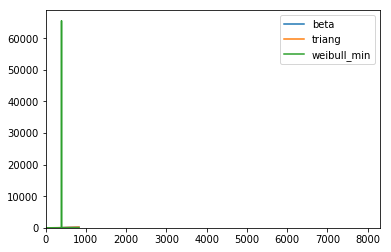


Distribution parameters:
------------------------

Distribution: beta
Parameters: (1.4575446489619073, 2.18756216834912, 385.42516920581636, 8815.108381851802)

Distribution: triang
Parameters: (0.21742895973372867, 198.59269838151403, 9025.510235719186)

Distribution: weibull_min
Parameters: (0.12444170381263667, 395.9999999999999, 4.876535227332714)


In [22]:
# Divide the observed data into 100 bins for plotting (this can be changed)
number_of_bins = 100
bin_cutoffs = np.linspace(np.percentile(y,0), np.percentile(y,99),number_of_bins)

# Create the plot
h = plt.hist(y, bins = bin_cutoffs, color='0.75')

# Get the top three distributions from the previous phase
number_distributions_to_plot = 3
dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]

# Create an empty list to stroe fitted distribution parameters
parameters = []

# Loop through the distributions ot get line fit and paraemters

for dist_name in dist_names:
    # Set up distribution and store distribution paraemters
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    parameters.append(param)
    
    # Get line for each distribution (and scale to match observed data)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
    scale_pdf = np.trapz (h[0], h[1][:-1]) / np.trapz (pdf_fitted, x)
    pdf_fitted *= scale_pdf
    
    # Add the line to the plot
    plt.plot(pdf_fitted, label=dist_name)
    
    # Set the plot x axis to contain 99% of the data
    # This can be removed, but sometimes outlier data makes the plot less clear
    plt.xlim(0,np.percentile(y,99))

# Add legend and display plot

plt.legend()
plt.show()

# Store distribution paraemters in a dataframe (this could also be saved)
dist_parameters = pd.DataFrame()
dist_parameters['Distribution'] = (
        results['Distribution'].iloc[0:number_distributions_to_plot])
dist_parameters['Distribution parameters'] = parameters

# Print parameter results
print ('\nDistribution parameters:')
print ('------------------------')

for index, row in dist_parameters.iterrows():
    print ('\nDistribution:', row[0])
    print ('Parameters:', row[1] )

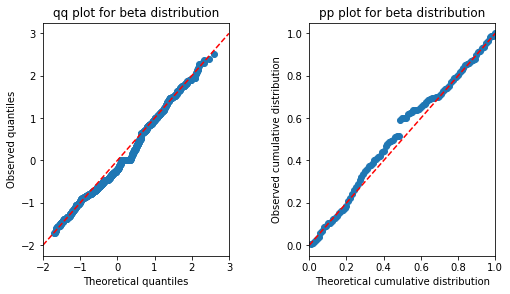

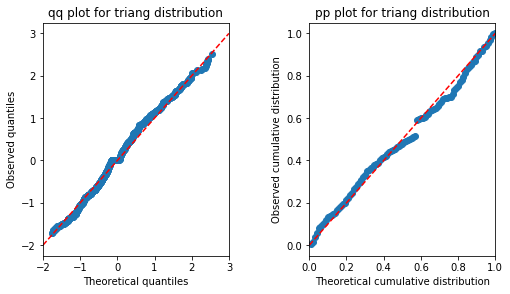

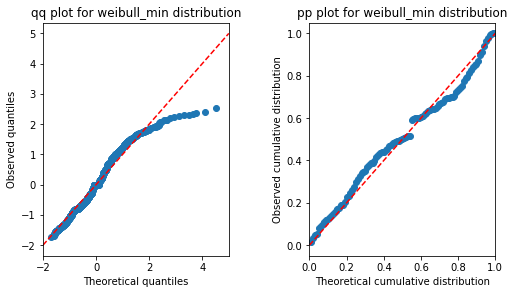

In [23]:
## qq and pp plots
    
data = y_std.copy()
data.sort()

# Loop through selected distributions (as previously selected)

for distribution in dist_names:
    # Set up distribution
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    
    # Get random numbers from distribution
    norm = dist.rvs(*param[0:-2],loc=param[-2], scale=param[-1],size = size)
    norm.sort()
    
    # Create figure
    fig = plt.figure(figsize=(8,5)) 
    
    # qq plot
    ax1 = fig.add_subplot(121) # Grid of 2x2, this is suplot 1
    ax1.plot(norm,data,"o")
    min_value = np.floor(min(min(norm),min(data)))
    max_value = np.ceil(max(max(norm),max(data)))
    ax1.plot([min_value,max_value],[min_value,max_value],'r--')
    ax1.set_xlim(min_value,max_value)
    ax1.set_xlabel('Theoretical quantiles')
    ax1.set_ylabel('Observed quantiles')
    title = 'qq plot for ' + distribution +' distribution'
    ax1.set_title(title)
    
    # pp plot
    ax2 = fig.add_subplot(122)
    
    # Calculate cumulative distributions
    bins = np.percentile(norm,range(0,101))
    data_counts, bins = np.histogram(data,bins)
    norm_counts, bins = np.histogram(norm,bins)
    cum_data = np.cumsum(data_counts)
    cum_norm = np.cumsum(norm_counts)
    cum_data = cum_data / max(cum_data)
    cum_norm = cum_norm / max(cum_norm)
    
    # plot
    ax2.plot(cum_norm,cum_data,"o")
    min_value = np.floor(min(min(cum_norm),min(cum_data)))
    max_value = np.ceil(max(max(cum_norm),max(cum_data)))
    ax2.plot([min_value,max_value],[min_value,max_value],'r--')
    ax2.set_xlim(min_value,max_value)
    ax2.set_xlabel('Theoretical cumulative distribution')
    ax2.set_ylabel('Observed cumulative distribution')
    title = 'pp plot for ' + distribution +' distribution'
    ax2.set_title(title)
    
    # Display plot    
    plt.tight_layout(pad=4)
    plt.show()